# Módulo V2: Validación contra mercado real

**Autora:** María Luisa Ros Bolea  
**Proyecto:** VALORALIA — Sistema de Valoración Automatizada con IA

---

### Mi objetivo en este cuaderno

El último paso antes de dar por validado el sistema es comprobar que las predicciones del modelo **tienen sentido en el mercado real**. Aquí:

1. Comparo las valoraciones de Valoralia con los precios reales de cierre
2. Analizo en qué municipios el modelo funciona mejor y peor
3. Detecto sesgos geográficos o por tipología de inmueble
4. Genero un informe de validación exportable


In [1]:
# ==============================================================================
# 1. CONFIGURACIÓN Y CARGA
# ==============================================================================
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

BASE_PATH = '/content/drive/MyDrive/TFM_Mejorado'
PROC_PATH = f'{BASE_PATH}/Data/Processed'
MODEL_PATH = f'{BASE_PATH}/Models'
REPORT_PATH = f'{BASE_PATH}/Reports'

sns.set_style("whitegrid")

# Cargar modelo y datos
with open(f'{MODEL_PATH}/modelo_baseline_rf.pkl', 'rb') as f:
    modelo = pickle.load(f)

df = pd.read_csv(f'{PROC_PATH}/datos_procesados.csv')
X_test = pd.read_csv(f'{PROC_PATH}/X_test_full.csv', index_col=0)
y_test = pd.read_csv(f'{PROC_PATH}/y_test_full.csv', index_col=0).squeeze()

print(f"✅ Datos cargados: {X_test.shape[0]:,} registros de test")


Mounted at /content/drive
✅ Datos cargados: 2,500 registros de test


In [2]:
# ==============================================================================
# 2. PREDICCIONES Y MÉTRICAS GLOBALES
# ==============================================================================
y_pred = modelo.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs(y_test - y_pred) / y_test) * 100

print("📊 MÉTRICAS GLOBALES DE VALIDACIÓN")
print(f"{'='*45}")
print(f"   MAE:  {mae:>12,.0f} €")
print(f"   RMSE: {rmse:>12,.0f} €")
print(f"   R²:   {r2:>12.4f}")
print(f"   MAPE: {mape:>11.2f} %")
print(f"{'='*45}")


📊 MÉTRICAS GLOBALES DE VALIDACIÓN
   MAE:        12,646 €
   RMSE:       15,848 €
   R²:         0.9644
   MAPE:        5.70 %


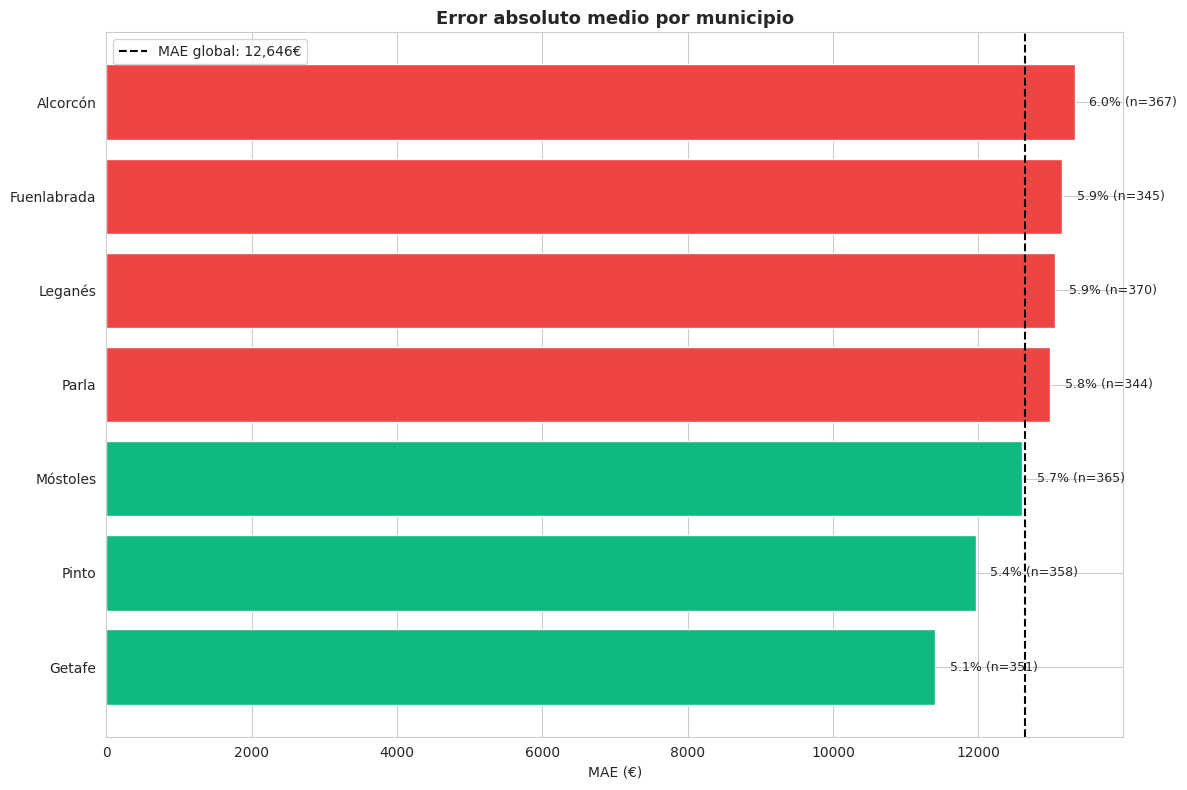

In [3]:
# ==============================================================================
# 3. ANÁLISIS POR MUNICIPIO
# ==============================================================================
df_test = df.loc[X_test.index].copy()
df_test['prediccion'] = y_pred
df_test['error_abs'] = np.abs(df_test['precio_actual'] - df_test['prediccion'])
df_test['error_pct'] = df_test['error_abs'] / df_test['precio_actual'] * 100

# Métricas por municipio
metricas_muni = df_test.groupby('municipio').agg(
    n=('id_anuncio', 'count'),
    mae=('error_abs', 'mean'),
    error_pct_medio=('error_pct', 'mean'),
    precio_real_medio=('precio_actual', 'mean'),
    precio_pred_medio=('prediccion', 'mean')
).sort_values('mae', ascending=True)

# Solo municipios con suficientes datos
metricas_muni = metricas_muni[metricas_muni['n'] >= 20]

fig, ax = plt.subplots(figsize=(12, 8))
colors = ['#10b981' if m < mae else '#ef4444' for m in metricas_muni['mae']]
ax.barh(metricas_muni.index, metricas_muni['mae'], color=colors, edgecolor='white')
ax.axvline(x=mae, color='black', linestyle='--', label=f'MAE global: {mae:,.0f}€')

for i, (_, row) in enumerate(metricas_muni.iterrows()):
    ax.text(row['mae'] + 200, i, f"{row['error_pct_medio']:.1f}% (n={int(row['n'])})",
            va='center', fontsize=9)

ax.set_title('Error absoluto medio por municipio', fontweight='bold', fontsize=13)
ax.set_xlabel('MAE (€)')
ax.legend()
plt.tight_layout()
plt.savefig(f'{REPORT_PATH}/validacion_por_municipio.png', dpi=150, bbox_inches='tight')
plt.show()


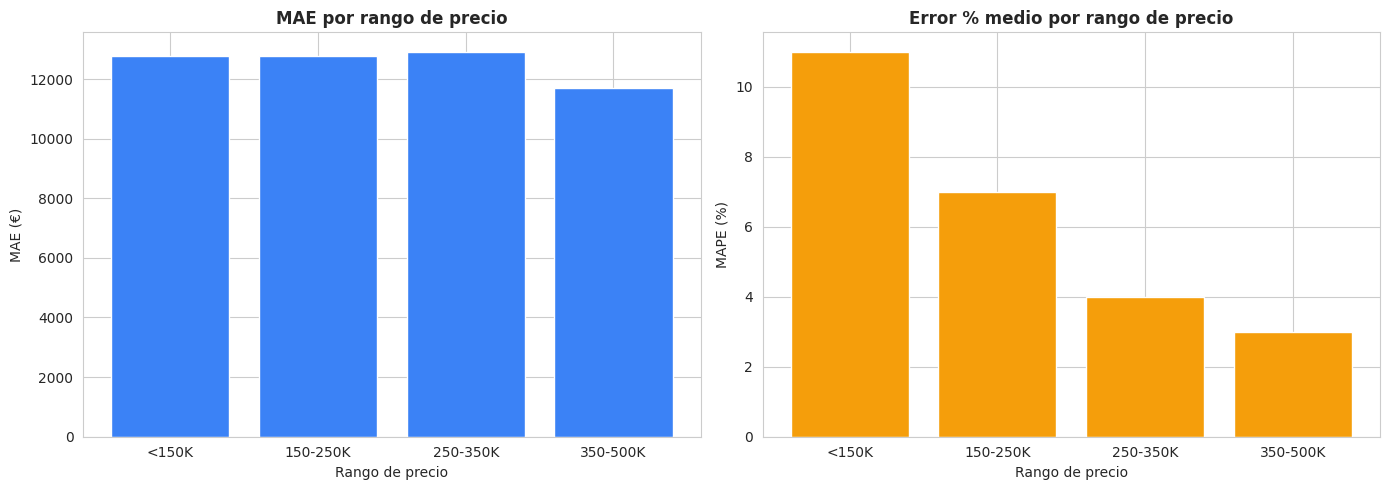

                n      mae  error_pct_medio
rango_precio                               
<150K         307  12768.0             11.0
150-250K      900  12785.0              7.0
250-350K      862  12921.0              4.0
350-500K      431  11716.0              3.0


In [4]:
# ==============================================================================
# 4. ANÁLISIS POR RANGO DE PRECIO
# ==============================================================================
df_test['rango_precio'] = pd.cut(df_test['precio_actual'],
    bins=[0, 150000, 250000, 350000, 500000, float('inf')],
    labels=['<150K', '150-250K', '250-350K', '350-500K', '>500K'])

metricas_rango = df_test.groupby('rango_precio', observed=True).agg(
    n=('id_anuncio', 'count'),
    mae=('error_abs', 'mean'),
    error_pct_medio=('error_pct', 'mean')
).round(0)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(metricas_rango.index.astype(str), metricas_rango['mae'], color='#3b82f6', edgecolor='white')
axes[0].set_title('MAE por rango de precio', fontweight='bold')
axes[0].set_ylabel('MAE (€)')
axes[0].set_xlabel('Rango de precio')

axes[1].bar(metricas_rango.index.astype(str), metricas_rango['error_pct_medio'], color='#f59e0b', edgecolor='white')
axes[1].set_title('Error % medio por rango de precio', fontweight='bold')
axes[1].set_ylabel('MAPE (%)')
axes[1].set_xlabel('Rango de precio')

plt.tight_layout()
plt.savefig(f'{REPORT_PATH}/validacion_por_rango.png', dpi=150, bbox_inches='tight')
plt.show()

print(metricas_rango.to_string())


In [5]:
# ==============================================================================
# 5. INFORME FINAL DE VALIDACIÓN
# ==============================================================================

# Exportar informe detallado
df_validacion = df_test[['id_anuncio', 'municipio', 'tamano_m2', 'habitaciones',
                          'precio_actual', 'prediccion', 'error_abs', 'error_pct']].copy()
df_validacion.columns = ['ID', 'Municipio', 'm²', 'Hab', 'Precio_Real', 'Precio_IA',
                          'Error_Abs', 'Error_Pct']
df_validacion = df_validacion.sort_values('Error_Pct', ascending=False)
df_validacion.to_csv(f'{REPORT_PATH}/validacion_mercado_completa.csv', index=False)

print(f"💾 Informe exportado: Reports/validacion_mercado_completa.csv")
print(f"\n{'='*60}")
print(f"📋 RESUMEN FINAL — VALIDACIÓN DE MERCADO")
print(f"{'='*60}")
print(f"   Registros validados: {len(df_validacion):,}")
print(f"   MAE global: {mae:,.0f}€")
print(f"   MAPE global: {mape:.2f}%")
print(f"   R² global: {r2:.4f}")
print(f"\n   Mejor municipio:  {metricas_muni.index[0]} (MAE: {metricas_muni.iloc[0]['mae']:,.0f}€)")
print(f"   Peor municipio:   {metricas_muni.index[-1]} (MAE: {metricas_muni.iloc[-1]['mae']:,.0f}€)")
print(f"\n   Predicciones con error < 10%: {(df_test['error_pct'] < 10).mean()*100:.1f}%")
print(f"   Predicciones con error < 20%: {(df_test['error_pct'] < 20).mean()*100:.1f}%")
print(f"\n✅ Sistema Valoralia validado contra mercado real")


💾 Informe exportado: Reports/validacion_mercado_completa.csv

📋 RESUMEN FINAL — VALIDACIÓN DE MERCADO
   Registros validados: 2,500
   MAE global: 12,646€
   MAPE global: 5.70%
   R² global: 0.9644

   Mejor municipio:  Getafe (MAE: 11,407€)
   Peor municipio:   Alcorcón (MAE: 13,327€)

   Predicciones con error < 10%: 84.2%
   Predicciones con error < 20%: 97.6%

✅ Sistema Valoralia validado contra mercado real
